In [1]:
import numpy as np
import scipy.io
import deepxde as dde

# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


2025-05-11 05:23:17.876514: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



In [2]:
# In[2]:


data = scipy.io.loadmat("Data/NLSG_modify_3.mat")

x = data["x"]               # shape: (256, 1)
t = data["t"].flatten()     # shape: (100,1)
u = data["usol3"]               # shape: (256, 100), complex-valued

# 若不是复数类型但以实部+虚部分开提供，请改为：
# u = data["u_real"] + 1j * data["u_imag"]

# 2. 提取实部和虚部
u_real = np.real(u)
u_imag = np.imag(u)


# 2. 提取初始条件 t=0

X_init = np.hstack((x, np.full_like(x, t[0])))    # (256, 2)
Y_init_u = u_real[:, 0:1]                         # (256, 1)
Y_init_v = u_imag[:, 0:1]

# 3. 定义几何区域
space_domain = dde.geometry.Interval(x.min(), x.max())
time_domain = dde.geometry.TimeDomain(t[0], t[-1])
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)






In [3]:
def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1]
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]







In [4]:
# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)



ic_u = dde.PointSetBC(X_init, Y_init_u, component=0)
ic_v = dde.PointSetBC(X_init, Y_init_v, component=1)




data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=10000,
    num_boundary=200,
    num_initial=200,
    train_distribution="pseudo",
)


In [12]:

def boundary_func_u_real(x):
    return u_real[0, :]  # 取 x=0 时的实部作为边界值

def boundary_func_u_imag(x):
    return u_imag[0, :]  # 取 x=0 时的虚部作为边界值

def boundary_func_v_real(x):
    return u_real[-1, :]  # 取 x=1 时的实部作为边界值

def boundary_func_v_imag(x):
    return u_imag[-1, :]  # 取 x=1 时的虚部作为边界值

# 设置边界条件
bc_u_real = dde.DirichletBC(geomtime, boundary_func_u_real, lambda x, on_boundary: on_boundary, component=0)
bc_u_imag = dde.DirichletBC(geomtime, boundary_func_u_imag, lambda x, on_boundary: on_boundary, component=1)

bc_v_real = dde.DirichletBC(geomtime, boundary_func_v_real, lambda x, on_boundary: on_boundary, component=0)
bc_v_imag = dde.DirichletBC(geomtime, boundary_func_v_imag, lambda x, on_boundary: on_boundary, component=1)

ic_u = dde.PointSetBC(X_init, Y_init_u, component=0)
ic_v = dde.PointSetBC(X_init, Y_init_v, component=1)


# 训练数据
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_real, bc_u_imag, bc_v_real, bc_v_imag, ic_u, ic_v],
    num_domain=10000,
    num_boundary=400,
    num_initial=400,
    train_distribution="pseudo",
)


In [5]:


# Network architecture
net = dde.nn.FNN([2] + [100] * 6 + [2], "tanh", "Glorot normal")

model = dde.Model(data, net)



model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=20000, display_every=1000)


# L-BFGS optimization.

# In[8]:


dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()


Compiling model...
Building feed-forward neural network...
'build' took 0.066240 s



/root/miniconda3/lib/python3.8/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2025-05-11 05:23:20.795461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-11 05:23:21.356579: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-05-11 05:23:21.356623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22028 MB memory:  -> device

'compile' took 1.529897 s

Training model...



2025-05-11 05:23:22.274951: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-05-11 05:23:22.446866: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7fd72c009a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-11 05:23:22.446901: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-11 05:23:22.466558: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-11 05:23:23.082032: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-05-11 05:23:23.082050: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-05-11 05:23:23.082118: W tensorflow/stream_executor/gpu/redzon

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [3.11e-03, 9.82e-03, 5.45e-01, 2.91e-06, 1.18e-01, 1.91e-04, 3.49e-01, 8.43e-01]    [3.11e-03, 9.82e-03, 5.45e-01, 2.91e-06, 1.18e-01, 1.91e-04, 3.49e-01, 8.43e-01]    []  
1000      [5.87e-03, 3.58e-03, 3.61e-06, 6.86e-05, 2.21e-07, 1.03e-04, 2.80e-03, 3.97e-04]    [5.87e-03, 3.58e-03, 3.61e-06, 6.86e-05, 2.21e-07, 1.03e-04, 2.80e-03, 3.97e-04]    []  
2000      [4.80e-03, 2.18e-03, 4.31e-04, 1.84e-05, 5.08e-06, 2.57e-05, 2.99e-03, 1.11e-04]    [4.80e-03, 2.18e-03, 4.31e-04, 1.84e-05, 5.08e-06, 2.57e-05, 2.99e-03, 1.11e-04]    []  
3000      [4.19e-03, 2.94e-03, 3.86e-04, 8.96e-06, 1.23e-03, 6.32e-06, 2.70e-03, 3.12e-04]    [4.19e-03, 2.94e-03, 3.86e-04, 8.96e-06, 1.23e-03, 6.32e-06, 2.70e-03, 3.12e-04]    []  
4000      [3.31e-03, 1.50e-03, 1.43e-04, 6.25e-06, 4.21e-04, 5.26e-06, 2.70e-0

2025-05-11 05:25:06.332310: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Step      Train loss                                                                          Test loss                                                                           Test metric
20000     [1.17e-04, 1.54e-04, 1.88e-04, 2.71e-07, 2.09e-04, 1.44e-07, 5.62e-05, 2.14e-05]    [1.17e-04, 1.54e-04, 1.88e-04, 2.71e-07, 2.09e-04, 1.44e-07, 5.62e-05, 2.14e-05]    []  
21000     [3.75e-06, 2.69e-06, 3.41e-08, 1.12e-07, 1.60e-08, 3.90e-08, 7.08e-07, 1.68e-07]    [3.75e-06, 2.69e-06, 3.41e-08, 1.12e-07, 1.60e-08, 3.90e-08, 7.08e-07, 1.68e-07]        
22000     [1.07e-06, 8.27e-07, 6.73e-09, 4.20e-08, 2.91e-09, 1.03e-08, 5.66e-07, 9.31e-08]    [1.07e-06, 8.27e-07, 6.73e-09, 4.20e-08, 2.91e-09, 1.03e-08, 5.66e-07, 9.31e-08]        
23000     [4.64e-07, 4.15e-07, 2.90e-09, 4.84e-08, 1.95e-09, 5.62e-09, 4.17e-07, 7.37e-08]    [4.64e-07, 4.15e-07, 2.90e-09, 4.84e-08, 1.95e-09, 5.62e-09, 4.17e-07, 7.37e-08]        
24000     [2.47e-07, 2.51e-07, 2.03e-09, 3.01e-08, 3.97e-09, 6.97e-09, 3.37e-0

(<deepxde.model.LossHistory at 0x7fdc01f4afa0>,
 <deepxde.model.TrainState at 0x7fdc01f4ab50>)

In [13]:
# Make prediction
X, T = np.meshgrid(x, t, indexing='ij')  # X, T: (256, 100)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
prediction = model.predict(X_star)

u_pred = prediction[:, 0]  # 实部预测
v_pred = prediction[:, 1]  # 虚部预测

from scipy.io import savemat
savemat('NLS_pred3.mat', {'u': u_pred, 'v':v_pred})



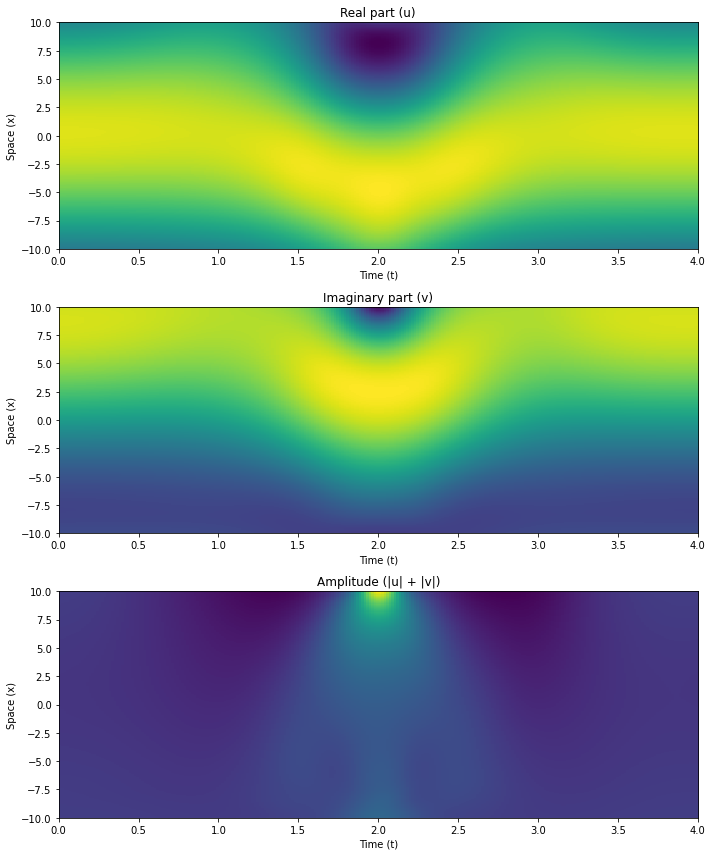

In [14]:
# 插值至完整网格
X, T = np.meshgrid(x, t, indexing='ij')  # X, T: (256, 100)
u_grid = griddata(X_star, u_pred, (X, T), method="cubic")
v_grid = griddata(X_star, v_pred, (X, T), method="cubic")

# 计算幅度
h = np.sqrt(u_grid ** 2 + v_grid ** 2)

# 绘制预测结果
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

ax[0].imshow(
    u_grid.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
ax[0].set_title("Real part (u)")
ax[0].set_xlabel("Time (t)")
ax[0].set_ylabel("Space (x)")
# ax[0].colorbar(label="u")

ax[1].imshow(
    v_grid.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
ax[1].set_title("Imaginary part (v)")
ax[1].set_xlabel("Time (t)")
ax[1].set_ylabel("Space (x)")
# ax[1].colorbar(label="v")

ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
ax[2].set_title("Amplitude (|u| + |v|)")
ax[2].set_xlabel("Time (t)")
ax[2].set_ylabel("Space (x)")
# ax[2].colorbar(label="Amplitude")

plt.tight_layout()
plt.show()